Compare all differentially private mechanisms. The results are at the end of the page.

In [6]:
import sys, os, time
import subprocess, shlex
import matplotlib.pyplot as plt     # matplotlib - plots
from IPython.utils import io
import numpy as np

In [2]:
class Dummy(dict):
    pass

In [3]:
CASE_FILE = '../example/case_genotypes.dat'
CONTROL_FILE = '../example/anticase_genotypes.dat'
SNP_TABLE_FILE = '../table.tmp'
JS_DISTANCE_FILE = '../js_distance.tmp'
CHISQUARE_FILE = '../chisquare.tmp'

Convert raw files to genotype tables.

In [4]:
subprocess.check_call("python raw_to_geno_table.py {case_file} {control_file} {outfile}".format(case_file=CASE_FILE, control_file=CONTROL_FILE, outfile=SNP_TABLE_FILE), shell=True)

0

Set common parameters.

In [7]:
PARAMS = Dummy()
PARAMS.NN_case = 1000  # number of cases
PARAMS.NN_control = 1000  # number of controls
PARAMS.MM_vec = np.array([1, 2, 3, 10])
# PARAMS.epsilon_vec = np.concatenate((np.arange(1, 20, 5), 
#                                      np.arange(21, 1522, 100)))
PARAMS.epsilon_vec = np.arange(1, 1522, 300)
PARAMS.NN_perturb = 20
# PARAMS.sig_level_vec = np.array([0.1, 0.05, 0.01])
PARAMS.sig_level_vec = np.array([0.1, 0.05])

In [8]:
perturb_result_dict = {}  # store the perturbation results

## Johnson & Shmatikov method

Count the number of SNPs.

In [9]:
snp_num = 0
with open(SNP_TABLE_FILE, 'r') as infile:
    for line in infile:
        snp_num += 1

Do perturbation and collect results.

In [13]:
start_time = time.time()
sensitivity = 1

perturb_result = {}
for sig_level in PARAMS.sig_level_vec:
    print("sig_level={}".format(sig_level))
    pval = sig_level / snp_num
    subprocess.check_call(shlex.split("python write_JS_distance.py -p {pval} {infile} {outfile}".format(infile=SNP_TABLE_FILE, outfile=JS_DISTANCE_FILE, pval=sig_level)))
    perturb_result[sig_level] = {}
    for MM in PARAMS.MM_vec:
        print("\tMM={}".format(MM))
        perturb_result[sig_level][MM] = {}
        for epsilon in PARAMS.epsilon_vec:
            print("\t\tepsilon={}".format(epsilon))
            perturbation = []
            for ii in range(PARAMS.NN_perturb):
                proc = subprocess.Popen(shlex.split('python get_JS_results.py {k} {e} {infile}'.format(k=MM, e=epsilon, infile=JS_DISTANCE_FILE)), stdout=subprocess.PIPE)
                perturbation.append(proc.communicate()[0].split())
            perturb_result[sig_level][MM][epsilon] = perturbation

perturb_result_dict['JS'] = perturb_result
print('Time spent: {} minutes.\n'.format(round((time.time() - start_time) / 60, 2)))

sig_level=0.1
	MM=1
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
	MM=2
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
	MM=3
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
	MM=10
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
sig_level=0.05
	MM=1
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
	MM=2
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
	MM=3
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
	MM=10
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
Time spent: 6.16 minutes.



## Exponential and Laplace Mechanism

Write file of $\chi^2$-statistics,

In [9]:
subprocess.check_call(shlex.split("python write_chisquare.py {infile} {outfile}".format(infile=SNP_TABLE_FILE, outfile=CHISQUARE_FILE)))

0

Exponential mechanism

In [10]:
start_time = time.time()
## perturb
perturb_result_no_sigLevel = {}
for MM in PARAMS.MM_vec:
    print("\tMM={}".format(MM))
    perturb_result_no_sigLevel[MM] = {}
    for epsilon in PARAMS.epsilon_vec:
        print("\t\tepsilon={}".format(epsilon))
        perturbation = []
        for ii in xrange(PARAMS.NN_perturb):
            proc = subprocess.Popen(shlex.split('python get_expo_results.py {k} {e} {n_case} {n_control} {infile}'.format(k=MM, e=epsilon, n_case=PARAMS.NN_case, n_control=PARAMS.NN_control, infile=CHISQUARE_FILE)), stdout=subprocess.PIPE)
            perturbation.append(proc.communicate()[0].split())
        perturb_result_no_sigLevel[MM][epsilon] = perturbation

perturb_result = {}
for sig_level in PARAMS.sig_level_vec:
    perturb_result[sig_level] = perturb_result_no_sigLevel

perturb_result_dict['Exponential'] = perturb_result
print('Time spent: {} minutes.\n'.format(round((time.time() - start_time) / 60, 2)))

	MM=1
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
	MM=2
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
	MM=3
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
	MM=10
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
Time spent: 1.43 minutes.



Laplace Mechanism.

In [11]:
start_time = time.time()
## perturb
perturb_result_no_sigLevel = {}
for MM in PARAMS.MM_vec:
    print("\tMM={}".format(MM))
    perturb_result_no_sigLevel[MM] = {}
    for epsilon in PARAMS.epsilon_vec:
        print("\t\tepsilon={}".format(epsilon))
        perturbation = []
        for ii in xrange(PARAMS.NN_perturb):
            proc = subprocess.Popen(shlex.split('python get_laplace_results.py {k} {e} {n_case} {n_control} {infile}'.format(k=MM, e=epsilon, n_case=PARAMS.NN_case, n_control=PARAMS.NN_control, infile=CHISQUARE_FILE)), stdout=subprocess.PIPE)
            perturbation.append(proc.communicate()[0].split())
        perturb_result_no_sigLevel[MM][epsilon] = perturbation

perturb_result = {}
for sig_level in PARAMS.sig_level_vec:
    perturb_result[sig_level] = perturb_result_no_sigLevel

perturb_result_dict['Laplace'] = perturb_result
print('Time spent: {} minutes.\n'.format(round((time.time() - start_time) / 60, 2)))

	MM=1
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
	MM=2
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
	MM=3
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
	MM=10
		epsilon=1
		epsilon=301
		epsilon=601
		epsilon=901
		epsilon=1201
		epsilon=1501
Time spent: 0.93 minutes.



# Analysis

## Get the average number of SNPs recovered

Get the $\chi^2$-statistics.

In [14]:
name_score_tuples = []
with open(CHISQUARE_FILE, 'r') as infile:
    # skip header line
    garbage = infile.readline()
    for line in infile:
        name, score = line.split()
        name_score_tuples.append((name, float(score)))

name_score_dict = dict(name_score_tuples)
snp_scores = np.array([ss for name, ss in name_score_tuples])

In [16]:
perturb_result_utility = {}
for method in perturb_result_dict:
    perturb_result_utility[method] = {}
    for sig_level in perturb_result_dict[method]:
        perturb_result_utility[method][sig_level] = {}
        for MM in perturb_result_dict[method][sig_level]:
            perturb_result_utility[method][sig_level][MM] = {}
            for epsilon in perturb_result_dict[method][sig_level][MM]:
                M_highest_score = np.sort(snp_scores)[::-1][MM-1]
#                 full_top_snp_set = [name_score_tuples[ii][0] for ii in np.argsort(snp_scores)[::-1][:MM]]
#                 full_top_snp_set += [nn for nn, ss in name_score_tuples if ss >= M_highest_score]
#                 full_top_snp_set = set(full_top_snp_set)
                perturbed_snp_scores = [np.array(list(map(name_score_dict.get, vec))) 
                                        for vec in perturb_result_dict[method][sig_level][MM][epsilon]]
                snps_recovered = list(map(lambda vec: np.sum(vec >= M_highest_score), perturbed_snp_scores))
                perturb_result_utility[method][sig_level][MM][epsilon] = 1. * np.mean(snps_recovered) / MM


## Make some plots

In [18]:
## make plots bigger
import matplotlib
#matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']

In [24]:
MY_COLORS = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
import matplotlib.lines as lines
MARKERS = lines.Line2D.filled_markers
# MARKERS = ['v', r'$\Omega$', r'o']
LINE_STYLES = ['-', '--',  ':', '-.', '_' ]

### $\chi^2$-statistics sorted in descending order

Text(0.5, 0, 'Rank')

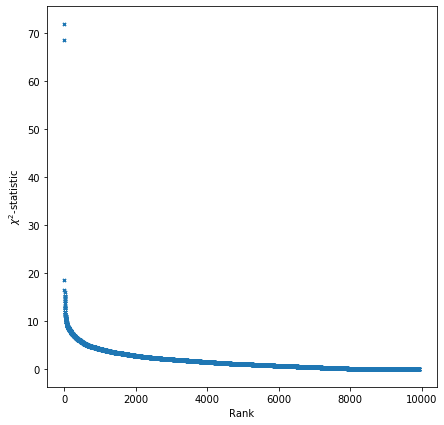

In [20]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(np.arange(len(snp_scores)), np.sort(snp_scores)[::-1], s=10, marker='x')
ax.set_ylabel('$\chi^2$-statistic')
ax.set_xlabel('Rank')

### Performance comparison of the DP mechanisms

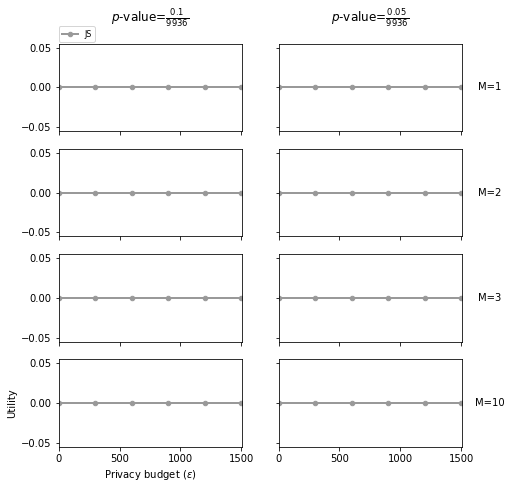

In [25]:
fig, ax_array = plt.subplots(len(PARAMS.MM_vec), len(PARAMS.sig_level_vec), 
                       sharex='col', sharey='row', figsize=(7,7))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
for ii, MM in enumerate(PARAMS.MM_vec):
    for jj, sig_level in enumerate(PARAMS.sig_level_vec):
        ax = ax_array[ii, jj]
        ax.set_xlim([0, np.max(PARAMS.epsilon_vec) + 5])
        for kk, method in enumerate(perturb_result_utility):
            xx = PARAMS.epsilon_vec
            yy = list(map(perturb_result_utility[method][sig_level][MM].get, xx))
            # ax.plot(xx, yy, color=MY_COLORS[kk % len(MY_COLORS)], label=method, 
            #         linestyle='-', marker=MARKERS[kk], markersize=5)
            ax.plot(xx, yy, color=MY_COLORS[kk % len(MY_COLORS)], label=method, 
                    linestyle=LINE_STYLES[kk], linewidth=2.0, marker=MARKERS[kk], 
                    markersize=4.5, )
        if ii == 0 and jj == 0:
            # ax.set_ylabel('Proportion of significant SNPs recovered')
            ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, 
                      prop={'size':8}, mode="tight", borderaxespad=0.)            
        if ii == 0:  # set column title on the first row
            ## set title
            ax.text(0.5, 1.25, 
                r'$p$-value=$\frac{%s}{%s}$' % (str(sig_level), str(snp_num)),
                horizontalalignment='center',
                fontsize="large",
                transform=ax.transAxes)
        if jj == len(PARAMS.sig_level_vec) - 1:  # set row title on the last column
            ax.text(1.15, 0.5, 'M={}'.format(MM),
                    horizontalalignment='center',
                    verticalalignment='center',
                    rotation=0,
                    transform=ax.transAxes)
        if ii == len(PARAMS.MM_vec) - 1 and jj == 0:
            ax.set_ylabel('Utility')
            ax.set_xlabel('Privacy budget ($\epsilon$)')